


1/1 [==============================] - 1s 1s/step


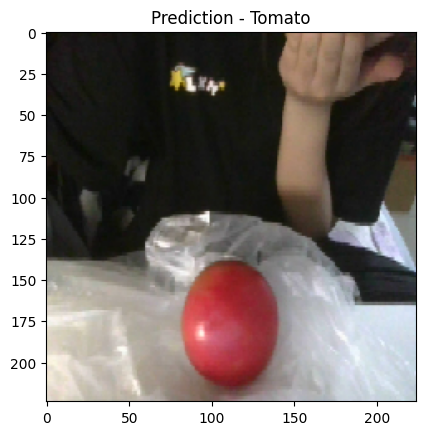

The predicted class of the image ./pic/photo.png is: Tomato
1/1 [==============================] - 0s 87ms/step


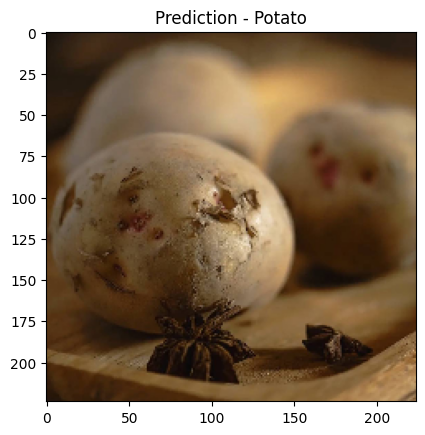

The predicted class of the image ./pic/potato.jpg is: Potato
1/1 [==============================] - 0s 86ms/step


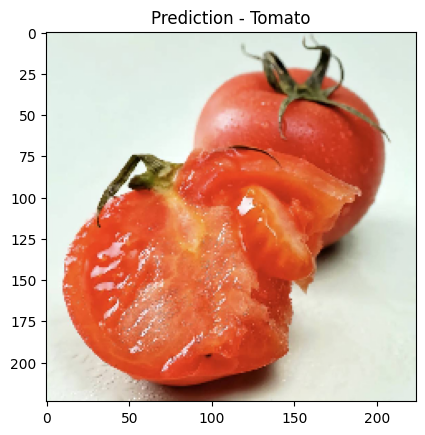

The predicted class of the image ./pic/tomato.jpg is: Tomato
All predicted classes: ['Tomato', 'Potato', 'Tomato']
['Tomato', 'Potato', 'Tomato']
['西红柿', '土豆', '西红柿']


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
# import pymysql
# import random
# import os
from test_img_recognition import predict,classify_images
app = Flask(__name__)
CORS(app)
# 需要识别的图片路径：
image_paths = [
    "./pic/photo.png",
    "./pic/potato.jpg",
    "./pic/tomato.jpg",
]
predicted_classes_result = classify_images(image_paths)
print(predicted_classes_result)
# 打印输出结果
# 定义一个英文到中文的映射字典
english_to_chinese_mapping = {
    'Tomato': '西红柿',
    'Potato': '土豆',
}
chinese_predicted_classes = [english_to_chinese_mapping.get(veg, veg) for veg in predicted_classes_result]
print(chinese_predicted_classes)

In [2]:
from sqlalchemy import create_engine, Column, Integer, String, DateTime, Float,update
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from extension import db
from models import Vegetable,Vegetable_2
import datetime
import random
# 替换为你的MySQL数据库信息
username = 'Userdb'
password = 'rootpop'
host = '39.106.144.42'  # 例如：'localhost' 或 '127.0.0.1'
port = '3306'  # 通常是 3306
database = 'userdb'
# 创建连接引擎
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')
# 创建会话

Session = sessionmaker(bind=engine)
session = Session()

In [3]:
messages = session.query(Vegetable_2).all()
for i in messages:
    print (i.vegetable_name, i.vegetable_sold, i.vegetable_inventory)

西红柿 0 100
土豆 0 100


In [4]:
result = []  # 初始化结果列表
# 确保predicted_classes_result中的每个元素都是字符串
chinese_predicted_classes = [str(category) for category in chinese_predicted_classes]

# 遍历数据库查询到的Vegetable记录
messages = session.query(Vegetable_2).all()
for i in range(len(chinese_predicted_classes)):
    for message in messages:
        # 检查当前记录的vegetable_name是否在predicted_classes_result中
        if chinese_predicted_classes[i] in message.vegetable_name :
            # 如果匹配，则将该记录的信息作为一个元组添加到result列表中
            # 这里不会去除重复，即使同一个商品信息因匹配多次predicted_classes_result中的类别也会被多次添加
            print(message.vegetable_name, message.vegetable_sold, message.vegetable_inventory)
            result.append((message.vegetable_name, message.vegetable_sold, message.vegetable_inventory))


西红柿 0 100
土豆 0 100
西红柿 0 100


In [5]:
result = tuple(result)
result

(('西红柿', 0, 100), ('土豆', 0, 100), ('西红柿', 0, 100))

In [6]:
vegetable_prices = {'西红柿': 2.50, '土豆': 3.0}
for vegetable_name,vegetable_sold,vegetable_inventory in result:
    price = vegetable_prices.get(vegetable_name, 0)
    print(price)

2.5
3.0
2.5


In [8]:
from sqlalchemy import update
cart_data = []
# 初始化已分配数量的字典
vegetable_prices = {'西红柿': 2.50, '土豆': 3.0}
allocated_quantities = {}
for vegetable_name,vegetable_sold,vegetable_inventory in result:
    # 获取当前商品的分配值
    vegetable_prices = {'西红柿': 2.50, '土豆': 3.0}
    allocated_quantity_for_item = allocated_quantities.get(vegetable_name, 0)
    remaining_inventory = vegetable_inventory - allocated_quantity_for_item

    if remaining_inventory > 0:
        # 生成一个在1到库存量之间的随机分配数量
        allocated_quantity = random.randint(1, remaining_inventory)
        print(f"随机生成的数量为：{allocated_quantity}")
        allocated_quantities[vegetable_name] = allocated_quantity
        print(f'商品已分配数量：{allocated_quantity}')

        vegetable_price = vegetable_prices.get(vegetable_name, 0)
        subtotal = allocated_quantity * vegetable_price
        print(vegetable_price)
        # 更新数据库中的vegetable_sold和vegetable_inventory（如果需要的话，通常不直接在原数据上加减）
        # 注意：实际操作中，更新库存和销量可能需要更复杂的逻辑来确保数据一致性
        # 下面是示例逻辑，但请注意这只是一个简化示例，并未直接反映到原result中
        
        message2 = Vegetable(vegetable_name=vegetable_name,vegetable_sold=allocated_quantity,
                             vegetable_inventory=remaining_inventory - allocated_quantity,vegetable_price = vegetable_price)
        session.add(message2)
        update_statement = (
            update(Vegetable_2)
            .where(vegetable_name == Vegetable_2.vegetable_name)
            .values(
                vegetable_inventory=Vegetable_2.vegetable_inventory - allocated_quantity,
                vegetable_sold = allocated_quantity,
            )
        )
        session.execute(update_statement)
        # 提交事务
        session.commit()
        print('123')
        cart_data.append({
            'img_url': '...',  # 应该是具体的图片URL
            'name': vegetable_name,
            'price': vegetable_price,  # 应该是从元组或数据库获取的实际价格
            'quantity': allocated_quantity,
            'subtotal':subtotal,  # 应该是计算出的子总价
        })
    else:
        print(f"No more {vegetable_name} available for allocation.")
cart_data

随机生成的数量为：16
商品已分配数量：16
2.5
123
随机生成的数量为：84
商品已分配数量：84
3.0
123
随机生成的数量为：13
商品已分配数量：13
2.5
123


[{'img_url': '...',
  'name': '西红柿',
  'price': 2.5,
  'quantity': 16,
  'subtotal': 40.0},
 {'img_url': '...',
  'name': '土豆',
  'price': 3.0,
  'quantity': 84,
  'subtotal': 252.0},
 {'img_url': '...',
  'name': '西红柿',
  'price': 2.5,
  'quantity': 13,
  'subtotal': 32.5}]

In [11]:
from flask_cors import CORS
app = Flask(__name__)
CORS(app)  # 允许所有源的跨域请求
app = Flask(__name__)
@app.route('/cart', methods = ['GET'])
def get_cart():
    return jsonify(cart_data)
if __name__ == '__main__':
    app.run( port=5555)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5555
Press CTRL+C to quit
127.0.0.1 - - [08/Jun/2024 15:03:41] "GET /cart HTTP/1.1" 200 -
